# Capstone project
# 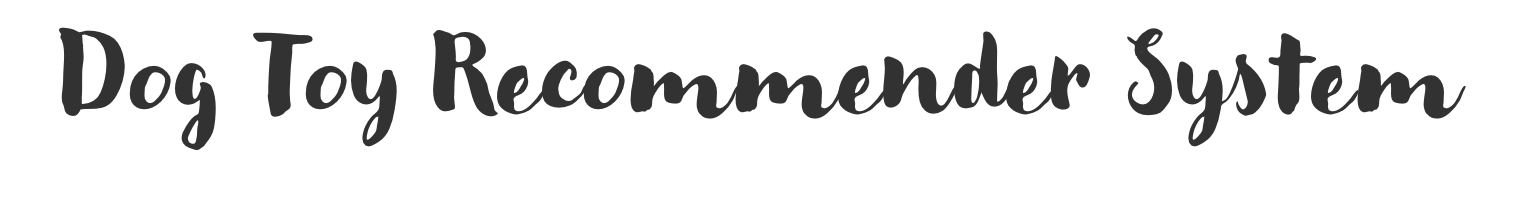

- by Qi Sun

**Purpose:**

The purpose of this project is to build a personalized dog toy recommender system for Chewy.com

**Dataset:**

There are two data sources for this project. One is scraped data from Chewy.com. There are 2729 records and 8 columns in this datasets. The columns include title, price, rating, link, category, sub-category, (item) description, and (item) key benefits. Another dataset is from a survey that I created for this project. 

**Method:**

In order to build a more reliable recommender system, I combined results from Content based and Collaborative Recommender Systems to get great results.

I also used topic modeling and feature importance from Random Forest model to build recommender system.


**Contribution:**

Since my recommender system put more focus on the items not users, it is featured by using different methods to increase the accuracy of my recommender system, which is different from all other existing recommender systems. These include:

1. Build topic modeling
2. Calculate feature importance for numerical variables 
3. Methods to evaluate the model

**Stakeholders:**

This recommender system can be used by start-up companies with few users rating data





In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from bs4 import BeautifulSoup 
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter

from sklearn.metrics.pairwise import linear_kernel, cosine_similarity


# Part 1. Load data

In [2]:
# read data from GitHub
chew_df = pd.read_csv('https://raw.githubusercontent.com/susanqisun/capstone/main/chewtoy_df.csv')
fetch_df = pd.read_csv('https://raw.githubusercontent.com/susanqisun/capstone/main/fetchtoy_df.csv')
interactive_df = pd.read_csv('https://raw.githubusercontent.com/susanqisun/capstone/main/interactivetoy_df.csv')
plush_df = pd.read_csv('https://raw.githubusercontent.com/susanqisun/capstone/main/plushtoy_df.csv')
ropetug_df = pd.read_csv('https://raw.githubusercontent.com/susanqisun/capstone/main/ropetugtoy_df.csv')


# Part 2. Clean the dataset

In [3]:
# merging the dataframes together into one large one, df
df = pd.merge(left=chew_df, right=fetch_df, how='outer')
df = pd.merge(left=df, right=interactive_df, how='outer')
df = pd.merge(left=df, right=plush_df, how='outer')
df = pd.merge(left=df, right=ropetug_df, how='outer')

df['price'] = df['price'].map(lambda x: x[1:])
df['price'] = df['price'].astype(float)
df['rating'] = df['rating'].map(lambda x: f'{x[0]}.{x[2]}')
df['rating'] = df['rating'].astype(float)

# To get rid of some characters from scraping the data that I don't want in the text 
df['descriptions'] = df['descriptions'].map(lambda x: x.replace('[', ''))
df['descriptions'] = df['descriptions'].map(lambda x: x.replace(']', ''))
df['descriptions'] = df['descriptions'].map(lambda x: x.replace('\\n', ''))
df['descriptions'] = df['descriptions'].map(lambda x: x.replace('\\xa0', ''))

# Doing the same things to key_benefits
df['key_benefits'] = df['key_benefits'].apply(lambda x: str(x).replace('[', ''))
df['key_benefits'] = df['key_benefits'].apply(lambda x: str(x).replace(']', ''))
df['key_benefits'] = df['key_benefits'].apply(lambda x: str(x).replace("\\", ''))
df['key_benefits'] = df['key_benefits'].apply(lambda x: str(x).replace("\'", ''))

# removing unneccesary characters
df['reviews'] = df['reviews'].apply(lambda x: BeautifulSoup(x).get_text())
df['reviews'] = df['reviews'].apply(lambda x: str(x).replace('[', ''))
df['reviews'] = df['reviews'].apply(lambda x: str(x).replace(']', ''))
df['reviews'] = df['reviews'].apply(lambda x: str(x).replace('\\', ''))
df['reviews'] = df['reviews'].apply(lambda x: str(x).replace('\n', ''))

df.head(3)

,title,price,descriptions,key_benefits,rating,reviews,link,subcat,cat
0,Nylabone Teething Pacifier Puppy Chew Toy,3.23,'Every puppy needs a pacifier to soothe teethi...,Designed to encourage positive play and teach ...,4.2,I read the reviews and thought we'd be safe. W...,https://www.chewy.com/nylabone-teething-pacifi...,moderate,chew toys
1,"KONG Puppy Dog Toy, Color Varies",6.99,"""The Puppy KONG dog toy is customized for a gr...",Unpredictable bounce is great for energetic pu...,4.3,"I have had dozens of dogs over the years, and ...",https://www.chewy.com/kong-puppy-dog-toy-color...,moderate,chew toys
2,Petstages Dogwood Tough Dog Chew Toy,8.83,"""Chewing is a natural behavior in all dogs, as...",Chew toy that combines real wood with syntheti...,4.2,My dogs like chasing sticks and the two of the...,https://www.chewy.com/petstages-dogwood-tough-...,moderate,chew toys


In [4]:
df['title02'] = df['title'].str.rsplit(',').str[0] 
df.head(2)

,title,price,descriptions,key_benefits,rating,reviews,link,subcat,cat,title02
0,Nylabone Teething Pacifier Puppy Chew Toy,3.23,'Every puppy needs a pacifier to soothe teethi...,Designed to encourage positive play and teach ...,4.2,I read the reviews and thought we'd be safe. W...,https://www.chewy.com/nylabone-teething-pacifi...,moderate,chew toys,Nylabone Teething Pacifier Puppy Chew Toy
1,"KONG Puppy Dog Toy, Color Varies",6.99,"""The Puppy KONG dog toy is customized for a gr...",Unpredictable bounce is great for energetic pu...,4.3,"I have had dozens of dogs over the years, and ...",https://www.chewy.com/kong-puppy-dog-toy-color...,moderate,chew toys,KONG Puppy Dog Toy


In [329]:
df.columns

Index(['title', 'price', 'descriptions', 'key_benefits', 'rating', 'reviews',
       'link', 'subcat', 'cat', 'title02'],
      dtype='object')

In [5]:
df = df.drop_duplicates(subset='title02', keep='first')
print(len(df))

2398


In [6]:
df02=df.copy()

# Part 3. Topic Modeling

I'll apply a NMF model to the toy description and determine the theme of each topic.

Here are the steps:

1. Prepare the text (description) for topic modeling
2. Find the best number of topics automatically by using the coherence score
3. Apply a NMF model
4. Find the highest quality topics among all the topics
5. Extract topics and Summarize those topics

Code reference: https://github.com/robsalgado/personal_data_science_projects/blob/master/topic_modeling_nmf/nlp_topic_utils.ipynb


## 3.1 Prepare the text for topic modeling

Below is the function I’m using to prepare text:

- tokenizes the text
- lower cases the text
- expands out contractions
- removes punctuation, stop words, numbers, single characters and words with extra spaces 


In [8]:
# Text Processing
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df02['desc02'] = pd.DataFrame(df02.descriptions.apply(lambda x: clean_text(x)))

df02.head(2)


,title,price,descriptions,key_benefits,rating,reviews,link,subcat,cat,title02,desc02
0,Nylabone Teething Pacifier Puppy Chew Toy,3.23,'Every puppy needs a pacifier to soothe teethi...,Designed to encourage positive play and teach ...,4.2,I read the reviews and thought we'd be safe. W...,https://www.chewy.com/nylabone-teething-pacifi...,moderate,chew toys,Nylabone Teething Pacifier Puppy Chew Toy,every puppy needs a pacifier to soothe teethin...
1,"KONG Puppy Dog Toy, Color Varies",6.99,"""The Puppy KONG dog toy is customized for a gr...",Unpredictable bounce is great for energetic pu...,4.3,"I have had dozens of dogs over the years, and ...",https://www.chewy.com/kong-puppy-dog-toy-color...,moderate,chew toys,KONG Puppy Dog Toy,the puppy kong dog toy is customized for a gro...


In [9]:
# Lemmatization
import spacy
nlp = spacy.load('en')

def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)


In [10]:
df02["question_lemmatize"] =df02.apply(lambda x: lemmatizer(x['desc02']), axis=1)

df02.head(3)

,title,price,descriptions,key_benefits,rating,reviews,link,subcat,cat,title02,desc02,question_lemmatize
0,Nylabone Teething Pacifier Puppy Chew Toy,3.23,'Every puppy needs a pacifier to soothe teethi...,Designed to encourage positive play and teach ...,4.2,I read the reviews and thought we'd be safe. W...,https://www.chewy.com/nylabone-teething-pacifi...,moderate,chew toys,Nylabone Teething Pacifier Puppy Chew Toy,every puppy needs a pacifier to soothe teethin...,every puppy need a pacifier to soothe teethe p...
1,"KONG Puppy Dog Toy, Color Varies",6.99,"""The Puppy KONG dog toy is customized for a gr...",Unpredictable bounce is great for energetic pu...,4.3,"I have had dozens of dogs over the years, and ...",https://www.chewy.com/kong-puppy-dog-toy-color...,moderate,chew toys,KONG Puppy Dog Toy,the puppy kong dog toy is customized for a gro...,the puppy kong dog toy be customize for a grow...
2,Petstages Dogwood Tough Dog Chew Toy,8.83,"""Chewing is a natural behavior in all dogs, as...",Chew toy that combines real wood with syntheti...,4.2,My dogs like chasing sticks and the two of the...,https://www.chewy.com/petstages-dogwood-tough-...,moderate,chew toys,Petstages Dogwood Tough Dog Chew Toy,chewing is a natural behavior in all dogs as i...,chew be a natural behavior in all dog as -PRON...


In [11]:
df02['question_lemmatize_clean'] = df02['question_lemmatize'].str.replace('-PRON-', '')

df02.head(2)


,title,price,descriptions,key_benefits,rating,reviews,link,subcat,cat,title02,desc02,question_lemmatize,question_lemmatize_clean
0,Nylabone Teething Pacifier Puppy Chew Toy,3.23,'Every puppy needs a pacifier to soothe teethi...,Designed to encourage positive play and teach ...,4.2,I read the reviews and thought we'd be safe. W...,https://www.chewy.com/nylabone-teething-pacifi...,moderate,chew toys,Nylabone Teething Pacifier Puppy Chew Toy,every puppy needs a pacifier to soothe teethin...,every puppy need a pacifier to soothe teethe p...,every puppy need a pacifier to soothe teethe p...
1,"KONG Puppy Dog Toy, Color Varies",6.99,"""The Puppy KONG dog toy is customized for a gr...",Unpredictable bounce is great for energetic pu...,4.3,"I have had dozens of dogs over the years, and ...",https://www.chewy.com/kong-puppy-dog-toy-color...,moderate,chew toys,KONG Puppy Dog Toy,the puppy kong dog toy is customized for a gro...,the puppy kong dog toy be customize for a grow...,the puppy kong dog toy be customize for a grow...


In [12]:
# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['dog', 'toy', 'dogs', 'toys', 'one','every','pet','make','fringe', 'studio','shop','nylabone','kong','chuckit','use','nerf','thing','ruff','item']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))

# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    #text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 2]
    text = [each for each in text if ' ' not in each]
    return text

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

def word_count(text):
    return len(str(text).split(' '))

In [13]:
# Get the word count
df02['word_count'] = df02['question_lemmatize_clean'].apply(word_count)
df02['word_count'].mean()


166.44036697247705

In [14]:
# Process the text 
df02['processed_text'] = df02['question_lemmatize_clean'].apply(process_text)
df02.head(3)


,title,price,descriptions,key_benefits,rating,reviews,link,subcat,cat,title02,desc02,question_lemmatize,question_lemmatize_clean,word_count,processed_text
0,Nylabone Teething Pacifier Puppy Chew Toy,3.23,'Every puppy needs a pacifier to soothe teethi...,Designed to encourage positive play and teach ...,4.2,I read the reviews and thought we'd be safe. W...,https://www.chewy.com/nylabone-teething-pacifi...,moderate,chew toys,Nylabone Teething Pacifier Puppy Chew Toy,every puppy needs a pacifier to soothe teethin...,every puppy need a pacifier to soothe teethe p...,every puppy need a pacifier to soothe teethe p...,181,"[puppy, need, pacifier, soothe, teethe, pain, ..."
1,"KONG Puppy Dog Toy, Color Varies",6.99,"""The Puppy KONG dog toy is customized for a gr...",Unpredictable bounce is great for energetic pu...,4.3,"I have had dozens of dogs over the years, and ...",https://www.chewy.com/kong-puppy-dog-toy-color...,moderate,chew toys,KONG Puppy Dog Toy,the puppy kong dog toy is customized for a gro...,the puppy kong dog toy be customize for a grow...,the puppy kong dog toy be customize for a grow...,198,"[puppy, customize, grow, puppys, baby, tooth, ..."
2,Petstages Dogwood Tough Dog Chew Toy,8.83,"""Chewing is a natural behavior in all dogs, as...",Chew toy that combines real wood with syntheti...,4.2,My dogs like chasing sticks and the two of the...,https://www.chewy.com/petstages-dogwood-tough-...,moderate,chew toys,Petstages Dogwood Tough Dog Chew Toy,chewing is a natural behavior in all dogs as i...,chew be a natural behavior in all dog as -PRON...,chew be a natural behavior in all dog as help...,197,"[chew, natural, behavior, help, reduce, stress..."


In [17]:
# Get the top 20 most common words among all toy description
p_text = df02['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20
                               ),
    columns=['word', 'frequency']
)

top_20


,word,frequency
0,play,3895
1,pup,2445
2,supervise,2009
3,indestructible,1977
4,fun,1779
5,help,1607
6,playtime,1588
7,good,1551
8,pal,1438
9,long,1278


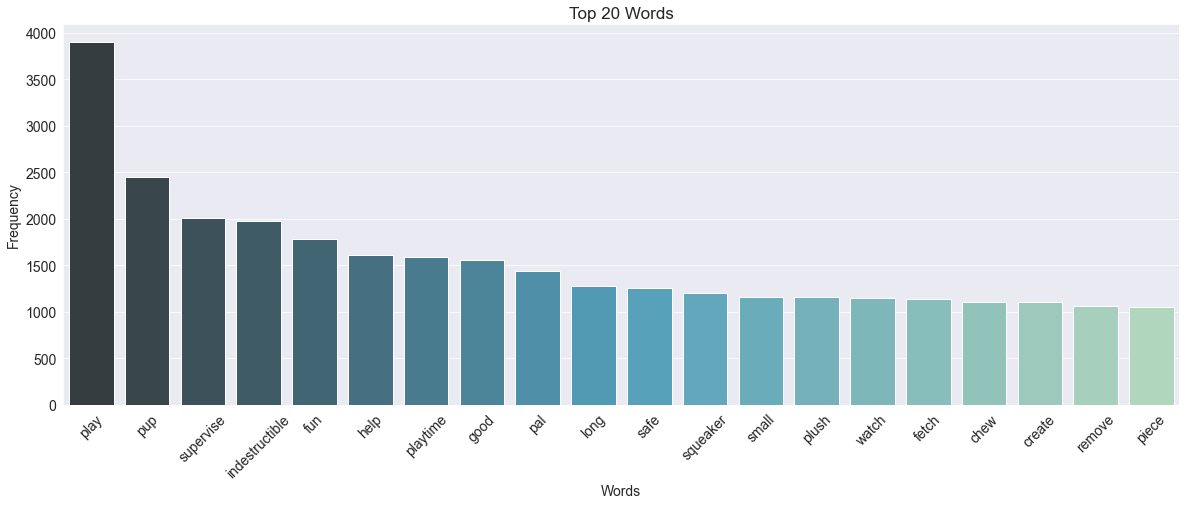

In [18]:
# Plot a bar chart for the top 20 most frequently occurring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

plt.show()

## 3.2 Automatically Select the Best Number of Topics

To evaluate the best number of topics, I'll use the coherence score. There are a few different types of coherence score with the two most popular being c_v and u_mass. 

c_v is more accurate while u_mass is faster. I’ll be using c_v here which ranges from 0 to 1 with 1 being perfectly coherent topics.

Next, I’ll use gensim to get the best number of topics with the coherence score and then use that number of topics for the sklearn implementation of NMF.


Code reference: https://github.com/robsalgado/personal_data_science_projects/blob/master/topic_modeling_nmf/topic_modeling_cnn.ipynb



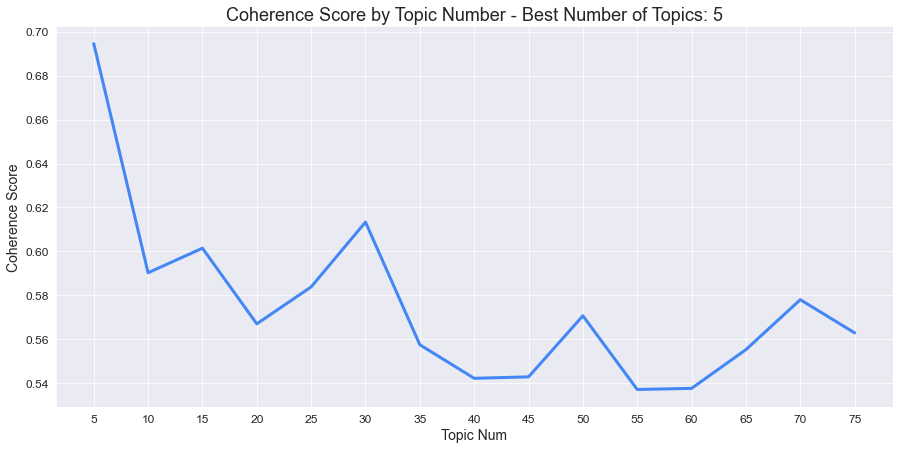

In [20]:

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df02['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.95,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()


**Results:**

>After the model is run we can visually inspect the coherence score by topic 5 was the number of topics that returned the highest coherence score and it drops off pretty fast after that.



## 3.3 Apply NMF model 

Extracting topics is a good unsupervised data-mining technique to discover the underlying relationships between texts. There are many different approaches and I’m going to focus on NMF. 



In [21]:
# Now use the number of topics with the highest coherence score to run the 
# sklearn nmf model

texts = df02['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 1),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)



In [22]:
# Use the top words for each cluster by tfidf weight to create 'topics'
# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 10

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()


,0,1,2,3,4,5,6,7,8,9,topics
0,play,pal,long,safe,create,equal,truly,importantly,case,break,play pal long safe create equal truly importan...
1,internal,plush,damage,small,child,reach,blockage,discontinue,present,hazard,internal plush damage small child reach blocka...
2,tuffy,layer,washable,machine,sew,float,outdoor,indoor,protective,pouch,tuffy layer washable machine sew float outdoor...
3,ball,tennis,rubber,fetch,launcher,throw,bounce,durable,design,game,ball tennis rubber fetch launcher throw bounce...
4,treat,chew,flavor,bone,tooth,starmark,puppy,clean,dental,busy,treat chew flavor bone tooth starmark puppy cl...


In [23]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df

,topic_num,topics
0,0,play pal long safe create equal truly importan...
1,1,internal plush damage small child reach blocka...
2,2,tuffy layer washable machine sew float outdoor...
3,3,ball tennis rubber fetch launcher throw bounce...
4,4,treat chew flavor bone tooth starmark puppy cl...


**Results:**

From the results of top 10 words in each topic above, I summarized the topic manually below:

* The first topic is about toy with hign safety. 
* The second topic is about toy of small size. 
* The third topic is about tuffy and washable toy. 
* The fourth topic is about fetch toy and toy shape. 
* The fifth topic is about chew toy for puppy and dental cleaning.

## 3.4 Merge topic number with the original dataset

In [24]:
# Creating a temp df with the url and topic num to join on
url = df02['link'].tolist()

df_temp = pd.DataFrame({
    'link': url,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df02,
    merged_topic,
    on='link',
    how='left'
)

df_topics = df_topics.drop(
    'processed_text',
    axis=1
)

df_topics.head()

,title,price,descriptions,key_benefits,rating,reviews,link,subcat,cat,title02,desc02,question_lemmatize,question_lemmatize_clean,word_count,topic_num,topics
0,Nylabone Teething Pacifier Puppy Chew Toy,3.23,'Every puppy needs a pacifier to soothe teethi...,Designed to encourage positive play and teach ...,4.2,I read the reviews and thought we'd be safe. W...,https://www.chewy.com/nylabone-teething-pacifi...,moderate,chew toys,Nylabone Teething Pacifier Puppy Chew Toy,every puppy needs a pacifier to soothe teethin...,every puppy need a pacifier to soothe teethe p...,every puppy need a pacifier to soothe teethe p...,181,4,treat chew flavor bone tooth starmark puppy cl...
1,"KONG Puppy Dog Toy, Color Varies",6.99,"""The Puppy KONG dog toy is customized for a gr...",Unpredictable bounce is great for energetic pu...,4.3,"I have had dozens of dogs over the years, and ...",https://www.chewy.com/kong-puppy-dog-toy-color...,moderate,chew toys,KONG Puppy Dog Toy,the puppy kong dog toy is customized for a gro...,the puppy kong dog toy be customize for a grow...,the puppy kong dog toy be customize for a grow...,198,4,treat chew flavor bone tooth starmark puppy cl...
2,Petstages Dogwood Tough Dog Chew Toy,8.83,"""Chewing is a natural behavior in all dogs, as...",Chew toy that combines real wood with syntheti...,4.2,My dogs like chasing sticks and the two of the...,https://www.chewy.com/petstages-dogwood-tough-...,moderate,chew toys,Petstages Dogwood Tough Dog Chew Toy,chewing is a natural behavior in all dogs as i...,chew be a natural behavior in all dog as -PRON...,chew be a natural behavior in all dog as help...,197,4,treat chew flavor bone tooth starmark puppy cl...
3,Nylabone Teething Rings Puppy Chew Toy,6.49,'Great for teething and tugging! The Puppy Tee...,Designed to encourage positive play and teach ...,4.1,It doesn't save fingers and hands as much from...,https://www.chewy.com/nylabone-teething-rings-...,moderate,chew toys,Nylabone Teething Rings Puppy Chew Toy,great for teething and tugging the puppy teeth...,great for teethe and tug the puppy teethe ring...,great for teethe and tug the puppy teethe ring...,164,0,play pal long safe create equal truly importan...
4,Nylabone Puppy Teething X Bone Beef Flavored P...,6.82,'Curious puppies have met their match with the...,Non-edible dog toy is made for teething puppie...,4.1,This is a great shoe for a tiny puppy in there...,https://www.chewy.com/nylabone-puppy-teething-...,moderate,chew toys,Nylabone Puppy Teething X Bone Beef Flavored P...,curious puppies have met their match with the ...,curious puppy have meet -PRON- match with the ...,curious puppy have meet match with the nylabo...,170,4,treat chew flavor bone tooth starmark puppy cl...


In [25]:
# check the total records in each topic
df_topics['topic_num'].value_counts()

1    1017
0     663
4     355
3     242
2     121
Name: topic_num, dtype: int64

# Part 4. Prepare data for Recommender System

I will consider 'key_benefits' as an important parameter to recommend dog toys based on benefits of toys that are displayed on Chewy.com product webpage.
 

References:

https://github.com/jalajthanaki/Movie_recommendation_engine/blob/master/Movie_recommendation_engine.ipynb

https://github.com/ArmandDS/jobs_recommendations/blob/master/job_analysis_content_recommendation.ipynb



## 4.1 Clean text of the 'key_benefits' column

In [26]:
# https://github.com/ArmandDS/jobs_recommendations/blob/master/job_analysis_content_recommendation.ipynb

from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

stopwords = stopwords.words('english') + ['dog', 'toy', 'dogs', 'toys', 'one','every','pet','make','fringe', 'studio','shop','nylabone','kong','chuckit','use','nerf','thing','ruff','item']
stop_words_ = set(stopwords)

wn = WordNetLemmatizer()

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation) and len(token)>2   
  
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text) 
    text = text.replace("nbsp", "")
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)


In [28]:
df_topics['key_benefits'] = df_topics['key_benefits'].apply(clean_txt)
df_topics.head(2)

,title,price,descriptions,key_benefits,rating,reviews,link,subcat,cat,title02,desc02,question_lemmatize,question_lemmatize_clean,word_count,topic_num,topics
0,Nylabone Teething Pacifier Puppy Chew Toy,3.23,'Every puppy needs a pacifier to soothe teethi...,design encourage positive play teach puppy hea...,4.2,I read the reviews and thought we'd be safe. W...,https://www.chewy.com/nylabone-teething-pacifi...,moderate,chew toys,Nylabone Teething Pacifier Puppy Chew Toy,every puppy needs a pacifier to soothe teethin...,every puppy need a pacifier to soothe teethe p...,every puppy need a pacifier to soothe teethe p...,181,4,treat chew flavor bone tooth starmark puppy cl...
1,"KONG Puppy Dog Toy, Color Varies",6.99,"""The Puppy KONG dog toy is customized for a gr...",unpredictable bounce great energetic puppies h...,4.3,"I have had dozens of dogs over the years, and ...",https://www.chewy.com/kong-puppy-dog-toy-color...,moderate,chew toys,KONG Puppy Dog Toy,the puppy kong dog toy is customized for a gro...,the puppy kong dog toy be customize for a grow...,the puppy kong dog toy be customize for a grow...,198,4,treat chew flavor bone tooth starmark puppy cl...


## 4.2 Term Frequency Inverse Document Frequency (TFIDF)

I'll use a very popular technique in information retrieval named TF-IDF, which converts unstructured text into a vector structure where each word is represented by a position in the vector, and the value measures how relevant a given word is for an article. As all items will be represented in the same Vector Space Model, it is used to compute similarity between dog toy key benefits text.

## Term Frequency (TF)
“Data Science is awesome !” A simple way to start out is by eliminating documents that do not contain all three words “Data”,”is”, “Science”, and “awesome”, but this still leaves many documents. To further distinguish them, we might count the number of times each term occurs in each document; the number of times a term occurs in a document is called its term frequency.

The weight of a term that occurs in a document is simply proportional to the term frequency.

## Inverse Document Frequency(IDF):
While computing TF, all terms are considered equally important. However it is known that certain terms, such as “is”, “of”, and “that”, may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing IDF, an inverse document frequency factor is incorporated which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.

When we calculate IDF, it will be very low for the most occurring words such as stop words (because stop words such as “is” is present in almost all of the documents, and N/df will give a very low value to that word). 


In [29]:
#initializing tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform((df_topics['key_benefits'])) #fitting and transforming the vector


In [30]:
tfidf_matrix.shape

(2398, 3704)

## 4.3 Feature Importance

There are also some numberical variables in this dataset. In order to increase the accuracy of this recommender system, I would like to calculate a score by using the weight of each numberical variable. I need a coefficient for each feature, so I’m going to look at feature importances which are provided directly by the Random Forest model.

Also, I'll label the variable of 'subcat' that is useful for building the Random Forest model.

Reference:
https://github.com/egemenzeytinci/recommovie/blob/master/notebook/recommovie.ipynb



In [34]:
df03 = df_topics.copy()

In [35]:
df03 = df03.reset_index()
df03.head(2)

,index,title,price,descriptions,key_benefits,rating,reviews,link,subcat,cat,title02,desc02,question_lemmatize,question_lemmatize_clean,word_count,topic_num,topics
0,0,Nylabone Teething Pacifier Puppy Chew Toy,3.23,'Every puppy needs a pacifier to soothe teethi...,design encourage positive play teach puppy hea...,4.2,I read the reviews and thought we'd be safe. W...,https://www.chewy.com/nylabone-teething-pacifi...,moderate,chew toys,Nylabone Teething Pacifier Puppy Chew Toy,every puppy needs a pacifier to soothe teethin...,every puppy need a pacifier to soothe teethe p...,every puppy need a pacifier to soothe teethe p...,181,4,treat chew flavor bone tooth starmark puppy cl...
1,1,"KONG Puppy Dog Toy, Color Varies",6.99,"""The Puppy KONG dog toy is customized for a gr...",unpredictable bounce great energetic puppies h...,4.3,"I have had dozens of dogs over the years, and ...",https://www.chewy.com/kong-puppy-dog-toy-color...,moderate,chew toys,KONG Puppy Dog Toy,the puppy kong dog toy is customized for a gro...,the puppy kong dog toy be customize for a grow...,the puppy kong dog toy be customize for a grow...,198,4,treat chew flavor bone tooth starmark puppy cl...


In [36]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
df03['subcat02'] = labelencoder.fit_transform(df03['subcat'])
df03.head(3)


,index,title,price,descriptions,key_benefits,rating,reviews,link,subcat,cat,title02,desc02,question_lemmatize,question_lemmatize_clean,word_count,topic_num,topics,subcat02
0,0,Nylabone Teething Pacifier Puppy Chew Toy,3.23,'Every puppy needs a pacifier to soothe teethi...,design encourage positive play teach puppy hea...,4.2,I read the reviews and thought we'd be safe. W...,https://www.chewy.com/nylabone-teething-pacifi...,moderate,chew toys,Nylabone Teething Pacifier Puppy Chew Toy,every puppy needs a pacifier to soothe teethin...,every puppy need a pacifier to soothe teethe p...,every puppy need a pacifier to soothe teethe p...,181,4,treat chew flavor bone tooth starmark puppy cl...,4
1,1,"KONG Puppy Dog Toy, Color Varies",6.99,"""The Puppy KONG dog toy is customized for a gr...",unpredictable bounce great energetic puppies h...,4.3,"I have had dozens of dogs over the years, and ...",https://www.chewy.com/kong-puppy-dog-toy-color...,moderate,chew toys,KONG Puppy Dog Toy,the puppy kong dog toy is customized for a gro...,the puppy kong dog toy be customize for a grow...,the puppy kong dog toy be customize for a grow...,198,4,treat chew flavor bone tooth starmark puppy cl...,4
2,2,Petstages Dogwood Tough Dog Chew Toy,8.83,"""Chewing is a natural behavior in all dogs, as...",chew combine real wood synthetic strength non ...,4.2,My dogs like chasing sticks and the two of the...,https://www.chewy.com/petstages-dogwood-tough-...,moderate,chew toys,Petstages Dogwood Tough Dog Chew Toy,chewing is a natural behavior in all dogs as i...,chew be a natural behavior in all dog as -PRON...,chew be a natural behavior in all dog as help...,197,4,treat chew flavor bone tooth starmark puppy cl...,4


In [37]:
# set up X and y
X = df03[['price', 'word_count','topic_num','subcat02']]
y = df03['rating']

In [38]:
# Transform features by scaling each feature to a given range.
from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()
X_minmax = mm_scaler.fit_transform(X)


In [39]:
# build random forest model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor().fit(X_minmax, y)


In [40]:
# Returns the coefficient of determination R^2 of the prediction.
rf.score(X_minmax, y)

0.8295602907822968

In [41]:
# create a function to get column importance
def imp_df(column_names, importances):
    data = {
        'Feature': column_names,
        'Importance': importances,
    }
    df = pd.DataFrame(data) \
        .set_index('Feature') \
        .sort_values('Importance', ascending=False)
    
    return df

In [42]:
imp_df(X.columns, rf.feature_importances_)


,Importance
Feature,
word_count,0.445138
price,0.370455
subcat02,0.098533
topic_num,0.085875


**Findings:**
> 1. The variable of 'word_count' has the most importance, which is the total number of words in  a product key benefits. That means the more detailed benefits listed on the product webpage, the higher ratings that users gave.
> 2. Also, the price of a product is important to predict the ratings, which means dog toys with higher prices could make customers more satisfied. A toy with a higher price should have a better quality and material, and much safer for dog.  
> 3. The category and topic have least importance to predict the rating, which makes sense because a toy that dogs like to play is not affected by the toy's category and topic. 


In [43]:
# calculate scores

df03['score'] = (
    0.370455 * df03['price'] + 0.445138 * df03['word_count'] + 
    0.085875 * df03['topic_num'] + 0.098533 * df03['subcat02']
)

df03.head(2)


,index,title,price,descriptions,key_benefits,rating,reviews,link,subcat,cat,title02,desc02,question_lemmatize,question_lemmatize_clean,word_count,topic_num,topics,subcat02,score
0,0,Nylabone Teething Pacifier Puppy Chew Toy,3.23,'Every puppy needs a pacifier to soothe teethi...,design encourage positive play teach puppy hea...,4.2,I read the reviews and thought we'd be safe. W...,https://www.chewy.com/nylabone-teething-pacifi...,moderate,chew toys,Nylabone Teething Pacifier Puppy Chew Toy,every puppy needs a pacifier to soothe teethin...,every puppy need a pacifier to soothe teethe p...,every puppy need a pacifier to soothe teethe p...,181,4,treat chew flavor bone tooth starmark puppy cl...,4,82.504180
1,1,"KONG Puppy Dog Toy, Color Varies",6.99,"""The Puppy KONG dog toy is customized for a gr...",unpredictable bounce great energetic puppies h...,4.3,"I have had dozens of dogs over the years, and ...",https://www.chewy.com/kong-puppy-dog-toy-color...,moderate,chew toys,KONG Puppy Dog Toy,the puppy kong dog toy is customized for a gro...,the puppy kong dog toy be customize for a grow...,the puppy kong dog toy be customize for a grow...,198,4,treat chew flavor bone tooth starmark puppy cl...,4,91.464436


# Step 5. Survey data

I set up the survey by using Qualtrics. There are 10 toys listed on the survey.

The survey question is How likely would your dog rank the following items? (5 being favorite, and 1 least)

I received a total of 21 responses to the survey.

Survey link: https://yeshiva.co1.qualtrics.com/jfe/form/SV_3wOuB8VPL8SQgYJ


In [3]:
# survey results
survey = pd.read_csv('https://raw.githubusercontent.com/susanqisun/capstone/main/survey_results.csv')
survey


,userID,189,347,688,673,393,416,1450,354,997,1303
0,1,3,5,4,4,4,3,4,5,4,4
1,2,1,5,3,2,2,3,3,5,5,5
2,3,3,4,5,2,2,4,1,2,3,4
3,4,2,3,5,4,0,1,5,3,5,3
4,5,0,3,1,2,3,4,5,4,0,3
5,6,0,5,2,3,3,3,5,5,5,5
6,7,1,2,5,5,1,3,2,4,5,2
7,8,4,2,3,1,4,3,4,1,4,5
8,9,5,1,2,3,2,4,1,5,4,3
9,10,0,5,2,5,5,0,4,1,5,0


In [4]:
survey02 = survey.copy()

In [5]:
survey02.index = np.arange(1, len(survey02) + 1)
survey02

,userID,189,347,688,673,393,416,1450,354,997,1303
1,1,3,5,4,4,4,3,4,5,4,4
2,2,1,5,3,2,2,3,3,5,5,5
3,3,3,4,5,2,2,4,1,2,3,4
4,4,2,3,5,4,0,1,5,3,5,3
5,5,0,3,1,2,3,4,5,4,0,3
6,6,0,5,2,3,3,3,5,5,5,5
7,7,1,2,5,5,1,3,2,4,5,2
8,8,4,2,3,1,4,3,4,1,4,5
9,9,5,1,2,3,2,4,1,5,4,3
10,10,0,5,2,5,5,0,4,1,5,0


## 5.1 Top 3 products for each user

In [48]:
# https://stackoverflow.com/questions/28609667/pandas-find-column-name-and-value-with-max-and-second-max-value-for-each-row

def top(x):
    x.set_index('userID', inplace=True)
    df11 = pd.DataFrame({'1st Max':[],'Max1Value':[],'2nd Max':[],'Max2Value':[],'3rd Max':[],'Max3Value':[]})
    df11.index.name='User'
    df11.loc[x.index.values[0],['1st Max', '2nd Max','3rd Max']] = x.sum().nlargest(3).index.tolist()
    df11.loc[x.index.values[0],['Max1Value', 'Max2Value','Max3Value']] = x.sum().nlargest(3).values
    return df11

df_top = survey.groupby('userID').apply(top).reset_index(level=1, drop=True).reset_index()
df_top


,userID,1st Max,Max1Value,2nd Max,Max2Value,3rd Max,Max3Value
0,1,347,5.0,354,5.0,688,4.0
1,2,347,5.0,354,5.0,997,5.0
2,3,688,5.0,347,4.0,416,4.0
3,4,688,5.0,1450,5.0,997,5.0
4,5,1450,5.0,416,4.0,354,4.0
5,6,347,5.0,1450,5.0,354,5.0
6,7,688,5.0,673,5.0,997,5.0
7,8,1303,5.0,189,4.0,393,4.0
8,9,189,5.0,354,5.0,416,4.0
9,10,347,5.0,673,5.0,393,5.0


## 5.2 Average rating of each toy


Code reference: https://github.com/wwwbbb8510/baseline-rs/blob/master/item-based-collaborative-filtering.ipynb

In [6]:
survey03 = survey02.drop(['userID'], axis=1)

df_survey = survey03.stack().reset_index()
df_survey.columns=['UserId', 'productID', 'rating']

df_survey

,UserId,productID,rating
0,1,189,3
1,1,347,5
2,1,688,4
3,1,673,4
4,1,393,4
...,...,...,...
205,21,416,2
206,21,1450,5
207,21,354,2
208,21,997,5


In [8]:
df_survey.groupby(['productID'], as_index = False, sort = False).mean()

,productID,UserId,rating
0,189,11.0,2.523810
1,347,11.0,3.238095
2,688,11.0,3.285714
3,673,11.0,3.380952
4,393,11.0,2.857143
5,416,11.0,3.000000
6,1450,11.0,3.095238
7,354,11.0,3.333333
8,997,11.0,4.000000
9,1303,11.0,3.714286


In [7]:
rating_mean= df_survey.groupby(['productID'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['productID','rating_mean']]
rating_mean.sort_values('rating_mean', ascending=False)


,productID,rating_mean
8,997,4.000000
9,1303,3.714286
3,673,3.380952
7,354,3.333333
2,688,3.285714
1,347,3.238095
6,1450,3.095238
5,416,3.000000
4,393,2.857143
0,189,2.523810


# Step 6. SVD based Collaborative filtering

I used Singular Value Decomposition (SVD) from the Surprise library to minimise RMSE (Root Mean Square Error) and give great recommendations based on user's ratings.


In [60]:
df_survey = survey03.stack().reset_index()
df_survey.columns=['UserId', 'productID', 'rating']
df_survey

,UserId,productID,rating
0,1,189,3
1,1,347,5
2,1,688,4
3,1,673,4
4,1,393,4
...,...,...,...
205,21,416,2
206,21,1450,5
207,21,354,2
208,21,997,5


In [61]:
from surprise import Reader, Dataset, SVD

# surprise reader API to read the dataset
reader = Reader()

data = Dataset.load_from_df(df_survey, reader)
svd = SVD()
trainset = data.build_full_trainset()
svd.fit(trainset)


In [67]:
# example
svd.predict(1, 100)

Prediction(uid=1, iid=100, r_ui=None, est=3.675533153691794, details={'was_impossible': False})

**Results:**

For a toy with ID 100, we get an estimated prediction of 3.676. One startling feature of this recommender system is that it doesn't care what the toy is (or what it contains). It works purely on the basis of an assigned toy ID and tries to predict ratings based on how the other users have reviewed the toys.


# Step 7. Hybrid recommendation system

In this section, I will build a hybrid recommender that brings together content based and collaborative filter based engines. 

## 7.1 Similarity measures

The similarity measure is the measure of how much alike two data objects are. A similarity measure is a data mining or machine learning context is a distance with dimensions representing features of the objects. If the distance is small, the features are having a high degree of similarity. Whereas a large distance will be a low degree of similarity.

Generally, similarity are measured in the range 0 to 1 [0,1]. In the machine learning world, this score in the range of [0,1] is called the similarity score.

I'll use two different similarity distance measures to build two recommender engines and compare their performances.



### 7.1.1 Hybrid recommendation system using Cosine Similarity

The cosine similarity metric finds the normalized dot product of the two attributes. By determining the cosine similarity, we would effectively try to find the cosine of the angle between the two objects. The cosine of 0° is 1, and it is less than 1 for any other angle.


<img src="https://raw.githubusercontent.com/susanqisun/capstone/main/Screen%20Shot%202020-12-16%20at%208.29.20%20PM.png" width="500">

Reference:
https://dataaspirant.com/five-most-popular-similarity-measures-implementation-in-python/


In [64]:
df04=df03.copy()

In [88]:
df05 = df04[['index','title','score','topic_num','price','rating']]
df05.head(2)

,index,title,score,topic_num,price,rating
0,0,Nylabone Teething Pacifier Puppy Chew Toy,82.504180,4,3.23,4.2
1,1,"KONG Puppy Dog Toy, Color Varies",91.464436,4,6.99,4.3


In [263]:
def recommendations_cosine(userId, title):
    # finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)
    #Reverse mapping of the index
    indices = pd.Series(df04.index, index = df04['title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:51]
    toy_indices = [i[0] for i in sim_scores]
    toys02 = df04.iloc[toy_indices][['title', 'title02','rating', 'price','subcat','cat', 'topic_num','score','link','index']]
    
    toys02['est'] = toys02['index'].apply(lambda x: svd.predict(userId, toys02.loc[x]['index']).est)
    toys02['score02'] = ((toys02['est'] * toys02['score'])/toys02['price'])*toys02['rating']
    toys02 = toys02.sort_values('score02', ascending=False)
    
    cond1 = (df04.index.isin(toy_indices))
    index02 = df04[df04['title']==title]['index']
    #cond2 = (df04.topic_num.isin(df04.iloc[index02]['topic_num']))
    cond3 = (df04.rating > 0)
    recommend = toys02.loc[cond1 & cond3].sort_values(by='score02', ascending=False)
    toys_recommend = recommend[['title', 'index','rating', 'price','topic_num','score','link','score02']]
    return toys_recommend.head(10)


In [290]:
def recommendations_cosine_output(userId, title):
    print(df05.loc[df05['title']==title])
    print('**' * 40)
    rr = recommendations_cosine(1, 'KONG Tuggz Sloth Dog Toy')
    return rr


In [291]:
recommendations_cosine_output(1, 'KONG Tuggz Sloth Dog Toy')


      index                     title      score  topic_num  price  rating
1447   1447  KONG Tuggz Sloth Dog Toy  79.256675          1  15.99     3.0
********************************************************************************


,title,index,rating,price,topic_num,score,link,score02
1349,Charming Pet Animates Pig Squeaky Plush Dog Toy,1349,5.0,7.87,1,76.693719,https://www.chewy.com/charming-pet-animates-pi...,179.091681
1184,Frisco Wagazoo Plush Squeaking Elephant Dog Toy,1184,4.5,10.98,1,95.206216,https://www.chewy.com/frisco-wagazoo-plush-squ...,143.415411
1155,Frisco Wagazoo Plush Squeaking Giraffe Dog Toy,1155,4.5,10.98,1,95.206216,https://www.chewy.com/frisco-wagazoo-plush-squ...,143.415411
1493,Charming Pet Animates Lamb Squeaky Plush Dog Toy,1493,4.0,7.97,1,76.730764,https://www.chewy.com/charming-pet-animates-la...,141.544024
1132,Frisco Wagazoo Plush Squeaking Alligator Dog Toy,1132,4.3,10.98,1,95.206216,https://www.chewy.com/frisco-wagazoo-plush-squ...,137.041393
2213,Paws & Pals Y-Balls Rope Dog Toy,2213,2.5,6.95,4,103.220272,https://www.chewy.com/paws-pals-y-balls-rope-d...,136.471055
1265,KONG Sherps Donkey Dog Toy,1265,3.6,8.99,1,85.566250,https://www.chewy.com/kong-sherps-donkey-dog-t...,125.940570
1141,Frisco Wagazoo Plush Squeaking Triceratops Dog...,1141,4.2,12.08,1,95.613716,https://www.chewy.com/frisco-wagazoo-plush-squ...,122.186409
1412,Charming Pet Scrunch Bunch Bunny Squeaky Plush...,1412,5.0,9.59,1,61.751071,https://www.chewy.com/charming-pet-scrunch-bun...,118.335824
2274,"Dogit Minty Knotted Rope Tough Dog Toy, Large",2274,4.1,5.99,4,46.332109,https://www.chewy.com/dogit-minty-knotted-rope...,116.562661


### 7.1.2 Hybrid recommendation system using Euclidean Distance

Euclidean distance is the most common use of distance measure. In most cases when people say about distance, they will refer to Euclidean distance. Euclidean distance is also known as simply distance. When data is dense or continuous, this is the best proximity measure.

The Euclidean distance between two points is the length of the path connecting them. The Pythagorean theorem gives this distance between two points.

<img src="https://raw.githubusercontent.com/susanqisun/capstone/main/Screen%20Shot%202020-12-16%20at%208.52.14%20PM.png" width="500">

Reference: https://dataaspirant.com/five-most-popular-similarity-measures-implementation-in-python/


In [278]:
from sklearn.metrics.pairwise import euclidean_distances

def recommendations_euclidean(userId, title):
    # finding cosine similarity for the vectors
    D = euclidean_distances(tfidf_matrix)
    #cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)
    #Reverse mapping of the index
    indices02 = pd.Series(df04.index, index = df04['title']).drop_duplicates()
         
    idx02 = indices02[title]
    d_scores = list(enumerate(D[idx02]))
    d_scores = sorted(d_scores, key = lambda x: x[1], reverse = True)
    d_scores = d_scores[1:51]
    toy_indices11 = [i[0] for i in d_scores]
    toys12 = df04.iloc[toy_indices11][['title', 'title02','rating', 'price','subcat','cat', 'topic_num','score','link','index']]
    
    toys12['est'] = toys12['index'].apply(lambda x: svd.predict(userId, toys12.loc[x]['index']).est)
    toys12['score02'] = ((toys12['est'] * toys12['score'])/toys12['price'])*toys12['rating']
    toys12 = toys12.sort_values('score02', ascending=False)
    
    cond11 = (df04.index.isin(toy_indices11))
    index12 = df04[df04['title']==title]['index']
    #cond12 = (df04.topic_num.isin(df04.iloc[index12]['topic_num']))
    cond13 = (df04.rating > 0)
    recommend11 = toys12.loc[cond11 & cond13].sort_values(by='score02', ascending=False)
    toys_recommend02 = recommend11[['title', 'index','rating', 'price','topic_num','score','link','score02']]
    return toys_recommend02.head(10)



In [284]:
def recommendations_euclidean_output(userId, title):
    print(df05.loc[df05['title']==title])
    print('**' * 40)
    r = recommendations_euclidean(1, 'KONG Tuggz Sloth Dog Toy')
    return r


In [285]:
recommendations_euclidean_output(1, 'KONG Tuggz Sloth Dog Toy')

      index                     title      score  topic_num  price  rating
1447   1447  KONG Tuggz Sloth Dog Toy  79.256675          1  15.99     3.0
********************************************************************************


,title,index,rating,price,topic_num,score,link,score02
376,"Ethical Pet Sensory Ball Tough Dog Chew Toy, C...",376,3.6,4.60,0,82.274071,https://www.chewy.com/ethical-pet-sensory-ball...,236.661711
1197,Frisco Summer Fun Plush Suntan Lotion Dog Toy,1197,4.7,5.99,1,75.997263,https://www.chewy.com/frisco-summer-fun-plush-...,219.174152
439,Ethical Pet Play Strong Rubber Ball Tough Dog ...,439,4.0,5.91,3,83.907268,https://www.chewy.com/ethical-pet-play-strong-...,208.733635
1386,"ZippyPaws Polar Bear Miniz Dog Toy, 3 count",1386,5.0,5.72,0,64.682916,https://www.chewy.com/zippypaws-polar-bear-min...,207.818357
624,"Nerf Dog Atomic Flyer Dog Toy, Large",624,3.9,7.99,0,96.537448,https://www.chewy.com/nerf-dog-atomic-flyer-do...,173.194457
1128,Frisco Retro Fanny Pack Plush with Rope Squeak...,1128,4.5,6.98,1,72.357772,https://www.chewy.com/frisco-retro-fanny-pack-...,171.459922
619,"Chuckit! Flying Squirrel Dog Toy, Color Varies",619,4.3,7.99,0,81.402756,https://www.chewy.com/chuckit-flying-squirrel-...,161.020486
771,Planet Dog Orbee-Tuff Raspberry Treat Dispensi...,771,4.2,5.99,0,60.627157,https://www.chewy.com/planet-dog-orbee-tuff-ra...,156.246400
1339,Pet Qwerks Frog Sound Plush Dog Toy,1339,5.0,9.99,1,84.156153,https://www.chewy.com/pet-qwerks-frog-sound-pl...,154.814180
134,Planet Dog Orbee-Tuff Guru Treat Dispensing Do...,134,4.5,12.99,4,113.273238,https://www.chewy.com/planet-dog-orbee-tuff-gu...,144.228479


# Step 8. Recommender System Evaluation

I'll evaluate the learned recommender system by converting the ratings to negative and positive

<img src="https://raw.githubusercontent.com/susanqisun/capstone/main/Screen%20Shot%202020-12-18%20at%209.56.34%20AM.png" width="500">

**Metrics: Precision, Recall, F1**

Recommendation is viewed as information retrieval task:
Retrieve (recommend) all items which are predicted to be “good”.

* Precision: a measure of exactness, determines the fraction of relevant
items retrieved out of all items retrieved

Precision = True positive / (True positive+False Positive)

* Recall: a measure of completeness, determines the fraction of relevant
items retrieved out of all relevant items

Recall = True positive / (True Positive+False Negative)

* F1: The F1 Metric attempts to combine Precision and Recall into a single value for comparison purposes, which could be used to gain a more balanced view of performance.

## 8.1 Model 01 Evaluation
### Recommender system using Cosine Similarity 

In [ ]:
s=float(df04.loc[df04['title']==title]['score'])
df100=recommendations_cosine(userId, title)[['topic_num','index']]
df100['true'] = s
df100['predict'] = df100.apply(lambda x: x['score'] > x['true'], axis=1)


In [375]:
def tp (userId, title):
    s=float(df04.loc[df04['title']==title]['score'])
    t = float(df04.loc[df04['title']==title]['rating'])
    df100=recommendations_cosine(userId, title)[['rating','index']]
    a=df100.loc[df100['rating']>=t]
    df99=recommendations_cosine(userId, title)[['score','index']]
    b=df99.loc[df99['score']>=s]
    result = pd.merge(a, b, on="index")
    return len(result)
    
def fp (userId, title):
    s=float(df04.loc[df04['title']==title]['score'])
    t = float(df04.loc[df04['title']==title]['rating'])
    df100=recommendations_cosine(userId, title)[['rating','index']]
    c=df100.loc[df100['rating']<t]
    df99=recommendations_cosine(userId, title)[['score','index']]
    b=df99.loc[df99['score']>=s]
    result02 = pd.merge(c, b, on="index")
    return len(result02)

def fn (userId, title):
    s=float(df04.loc[df04['title']==title]['score'])
    t = float(df04.loc[df04['title']==title]['rating'])
    df100=recommendations_cosine(userId, title)[['rating','index']]
    a=df100.loc[df100['rating']>=t]
    df99=recommendations_cosine(userId, title)[['score','index']]
    b02=df99.loc[df99['score']<s]
    result03 = pd.merge(a, b02, on="index")
    return len(result03)

def tn (userId, title):
    s=float(df04.loc[df04['title']==title]['score'])
    t = float(df04.loc[df04['title']==title]['rating'])
    df100=recommendations_cosine(userId, title)[['rating','index']]
    a02=df100.loc[df100['rating']<t]
    df99=recommendations_cosine(userId, title)[['score','index']]
    b02=df99.loc[df99['score']<s]
    result04 = pd.merge(a02, b02, on="index")
    return len(result04)

def binary_eval_cosine (userId, title):
    precision = tp(userId, title) / (tp(userId, title) + fp(userId, title))
    recall = tp(userId, title) / (tp(userId, title) + fn(userId, title))
    F1 = 2*(precision*recall) / (precision + recall)
    return (precision, recall, F1)


In [376]:
binary_eval_cosine(1, 'KONG Tuggz Sloth Dog Toy')

(0.8333333333333334, 0.5555555555555556, 0.6666666666666667)

In [377]:
binary_eval_cosine(104, 'Charming Pet Ropes-A-Go-Go Gator Squeaky Plush Dog Toy')


(0.6, 0.375, 0.4615384615384615)

## 8.2 Model 02 Evaluation
### Recommender system using Euclidean Distance


In [378]:
def tp02 (userId, title):
    s=float(df04.loc[df04['title']==title]['score'])
    t = float(df04.loc[df04['title']==title]['rating'])
    df100=recommendations_euclidean(userId, title)[['rating','index']]
    a=df100.loc[df100['rating']>=t]
    df99=recommendations_euclidean(userId, title)[['score','index']]
    b=df99.loc[df99['score']>=s]
    result = pd.merge(a, b, on="index")
    return len(result)
    
def fp02 (userId, title):
    s=float(df04.loc[df04['title']==title]['score'])
    t = float(df04.loc[df04['title']==title]['rating'])
    df100=recommendations_euclidean(userId, title)[['rating','index']]
    c=df100.loc[df100['rating']<t]
    df99=recommendations_euclidean(userId, title)[['score','index']]
    b=df99.loc[df99['score']>=s]
    result02 = pd.merge(c, b, on="index")
    return len(result02)

def fn02 (userId, title):
    s=float(df04.loc[df04['title']==title]['score'])
    t = float(df04.loc[df04['title']==title]['rating'])
    df100=recommendations_euclidean(userId, title)[['rating','index']]
    a=df100.loc[df100['rating']>=t]
    df99=recommendations_euclidean(userId, title)[['score','index']]
    b02=df99.loc[df99['score']<s]
    result03 = pd.merge(a, b02, on="index")
    return len(result03)

def tn02 (userId, title):
    s=float(df04.loc[df04['title']==title]['score'])
    t = float(df04.loc[df04['title']==title]['rating'])
    df100=recommendations_euclidean(userId, title)[['rating','index']]
    a02=df100.loc[df100['rating']<t]
    df99=recommendations_euclidean(userId, title)[['score','index']]
    b02=df99.loc[df99['score']<s]
    result04 = pd.merge(a02, b02, on="index")
    return len(result04)

def binary_eval_euclidean (userId, title):
    precision02 = tp02(userId, title) / (tp02(userId, title) + fp02(userId, title))
    recall02 = tp02(userId, title) / (tp02(userId, title) + fn02(userId, title))
    F1a = 2*(precision02*recall02) / (precision02 + recall02)
    return (precision02, recall02, F1a)



In [379]:
binary_eval_euclidean(1, 'KONG Tuggz Sloth Dog Toy')

(1.0, 0.6, 0.7499999999999999)

In [380]:
binary_eval_euclidean(104, 'Charming Pet Ropes-A-Go-Go Gator Squeaky Plush Dog Toy')


(0.6, 0.42857142857142855, 0.5)

## 8.3 Compare models

In [381]:
def compare (userId, title):
    print('Cosine evaluation:',binary_eval_cosine(userId, title))
    print('**' * 40)
    print('Euclidean evaluation:',binary_eval_euclidean(userId, title))
    

In [382]:
compare(1, 'KONG Tuggz Sloth Dog Toy')

Cosine evaluation: (0.8333333333333334, 0.5555555555555556, 0.6666666666666667)
********************************************************************************
Euclidean evaluation: (1.0, 0.6, 0.7499999999999999)


In [383]:
compare(104, 'Charming Pet Ropes-A-Go-Go Gator Squeaky Plush Dog Toy')

Cosine evaluation: (0.6, 0.375, 0.4615384615384615)
********************************************************************************
Euclidean evaluation: (0.6, 0.42857142857142855, 0.5)


In [384]:
compare(201, 'JW Pet Play Place Butterfly Puppy Teether, Color Varies')

Cosine evaluation: (0.8888888888888888, 0.8888888888888888, 0.8888888888888888)
********************************************************************************
Euclidean evaluation: (0.875, 0.7777777777777778, 0.823529411764706)


In [385]:
compare(19, 'Petstages Dogwood Mesquite Tough Dog Chew Toy')

Cosine evaluation: (0.75, 0.8571428571428571, 0.7999999999999999)
********************************************************************************
Euclidean evaluation: (0.7777777777777778, 0.875, 0.823529411764706)


**Findings:**

>1. For some items, the precision, recall, and F1 scores of the model 01 with Cosine Similarity are higher than the model 02 with Euclidean Distance. However, for some other items, the model 02 with Euclidean Distance would have a better performance than the model 01 .

>2. For deployment, we can deploy both models, automatically select the best recommender model based on model performance for inputted item, and provide recommendations for customers.
